In [2]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics
import scipy.stats as stats


# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_sarimax import (
    prepare_sarimax_data,
    check_stationarity,
    plot_acf_pacf,
    fit_sarimax_model,
    analyze_residual_spike,
    ljung_box_test,
    forecast_sarimax_model,
    identify_peak_hours_sarimax,
    evaluate_sarimax_metrics,
    rolling_forecast_sarimax,
    generate_future_forecast_sarimax,
    group_forecast_by_hour,
    
)

from models.model_sarimax import (
    sarimax_grid_search,
    retrain_sarimax_model,
    ljung_box_test_residuals,
    forecast_with_refined_sarimax,
    analyze_peak_hours_sarimax_refined,
    evaluate_refined_sarimax_metrics,
    rolling_forecast_sarimax_refined,
    forecast_future_sarimax_model_refined,
    future_forecast_by_hour_sarimax_refined
)

 Working directory: /Users/sudishmakarki/My_project2


In [3]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [4]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for SARIMAX
train_series, test_series = prepare_sarimax_data(restaurant_train, restaurant_test)

In [5]:
# --- Grid Search for Best SARIMAX Parameters ---
results_df, best_params = sarimax_grid_search(train_series)

Starting SARIMAX Grid Search...
SARIMAX(1, 0, 0)x(1, 0, 0, 24) - AIC: 251557.05, BIC: 251582.45
SARIMAX(1, 0, 0)x(1, 1, 0, 24) - AIC: 243440.12, BIC: 243465.51
SARIMAX(1, 0, 0)x(1, 1, 1, 24) - AIC: 229740.93, BIC: 229774.79
SARIMAX(1, 1, 0)x(1, 0, 0, 24) - AIC: 256847.19, BIC: 256872.58
SARIMAX(1, 1, 0)x(1, 1, 0, 24) - AIC: 251494.52, BIC: 251519.91
SARIMAX(1, 1, 0)x(1, 1, 1, 24) - AIC: 237133.22, BIC: 237167.08
SARIMAX(1, 1, 1)x(1, 0, 0, 24) - AIC: 249267.45, BIC: 249301.31
SARIMAX(1, 1, 1)x(1, 1, 0, 24) - AIC: 243445.39, BIC: 243479.24
SARIMAX(1, 1, 1)x(1, 1, 1, 24) - AIC: 228612.73, BIC: 228655.05

Best SARIMAX Parameters Based on AIC:
order                 (1, 1, 1)
seasonal_order    (1, 1, 1, 24)
AIC               228612.730952
BIC               228655.048326
Name: 8, dtype: object


In [6]:
# --- Retrain the SARIMAX Model ---
best_order = best_params['order']
best_seasonal_order = best_params['seasonal_order']
results_sarimax_best = retrain_sarimax_model(train_series, best_order, best_seasonal_order)

                                     SARIMAX Results                                      
Dep. Variable:                      CustomerCount   No. Observations:                35064
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -114301.365
Date:                            Fri, 11 Apr 2025   AIC                         228612.731
Time:                                    00:28:39   BIC                         228655.048
Sample:                                01-01-2018   HQIC                        228626.210
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1379      0.005     25.962      0.000       0.128       0.148
ma.L1         -1.0597      0.002   

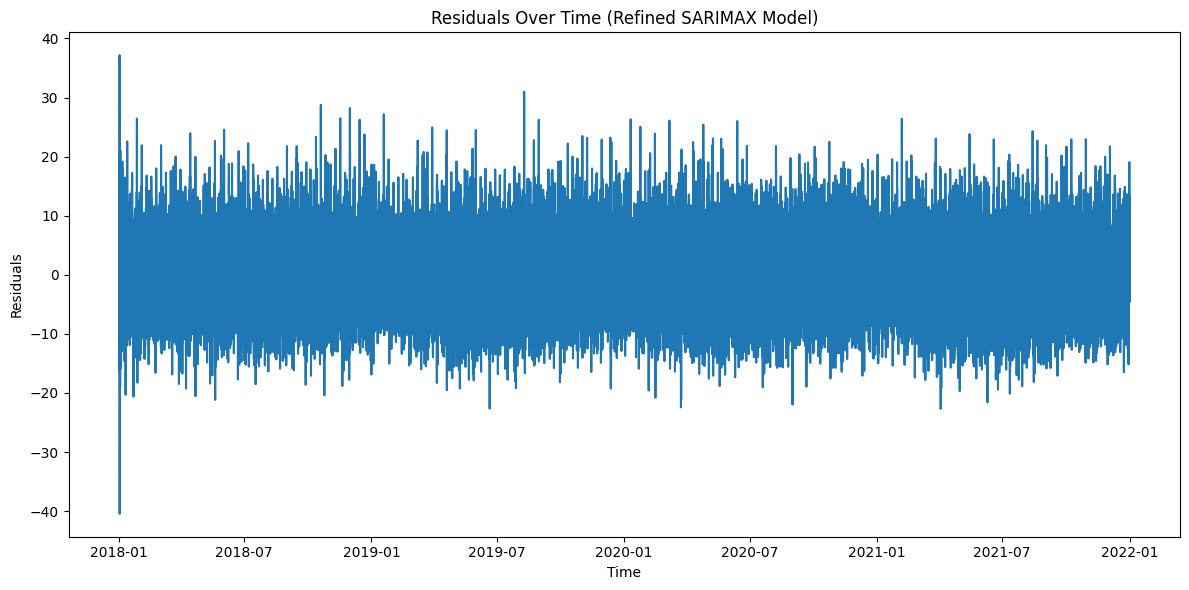

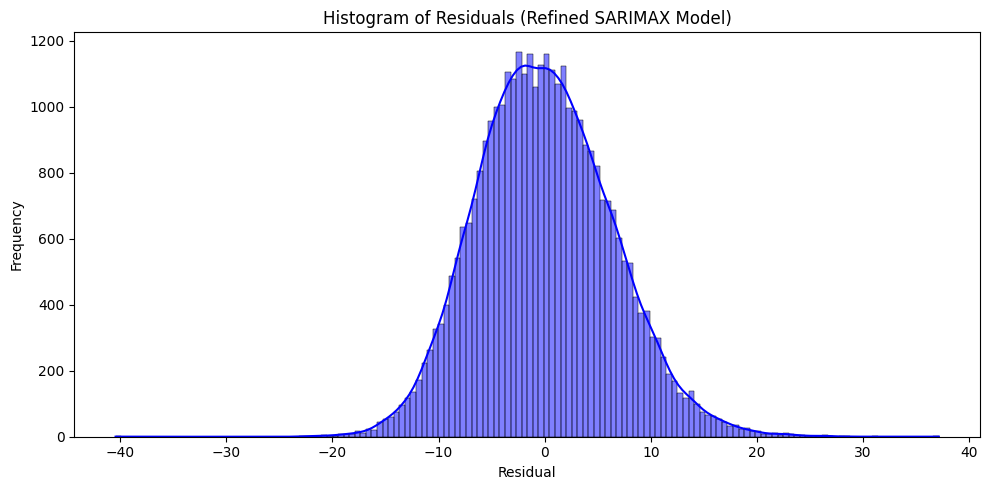

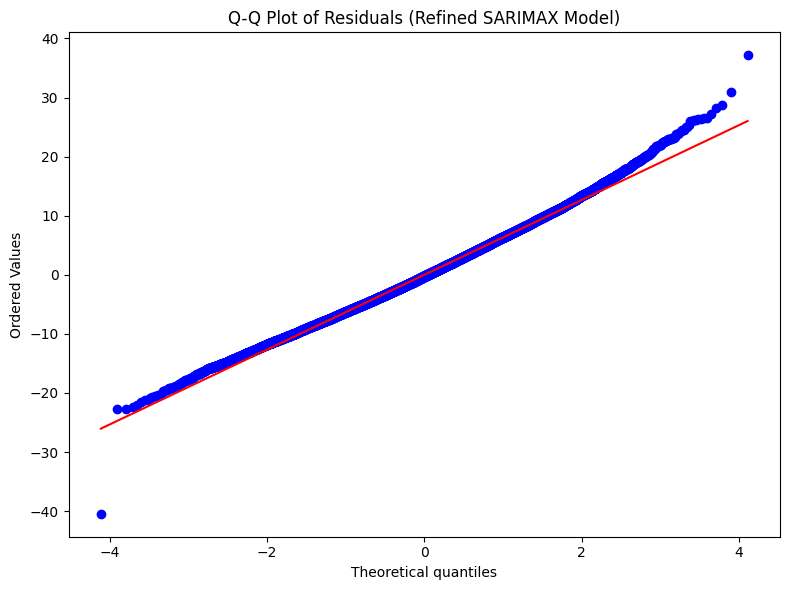

In [7]:
# --- Residual Diagnostics ---
residuals_refined = results_sarimax_best.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals_refined)
plt.title("Residuals Over Time (Refined SARIMAX Model)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(residuals_refined.dropna(), kde=True, color='blue')
plt.title("Histogram of Residuals (Refined SARIMAX Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals_refined.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Refined SARIMAX Model)")
plt.tight_layout()
plt.show()

In [8]:
# --- Ljung-Box Test ---
ljung_box_test_residuals(residuals_refined)

Ljung-Box Test Results (Refined SARIMAX Residuals):
       lb_stat     lb_pvalue
10  446.115109  1.408037e-89


,lb_stat,lb_pvalue
10,446.115109,1.408037e-89


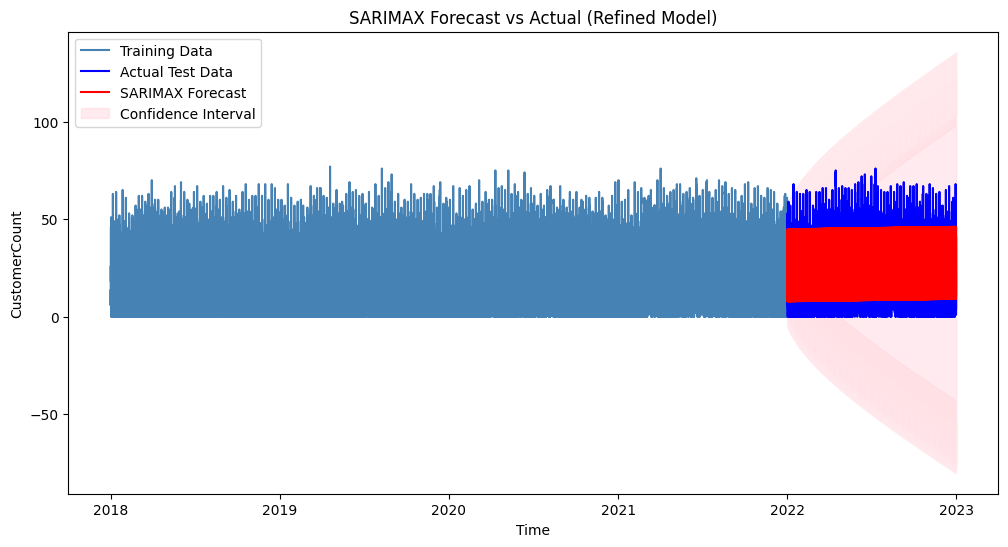

In [9]:
# --- Step 7: Forecast on Test Set ---
forecast_mean, forecast_ci = forecast_with_refined_sarimax(results_sarimax_best, test_series)

plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Refined Model)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.show()

In [10]:
# --- Step 8: Peak Hour Analysis ---
peak_hours_sr1, threshold, hourly_avg, forecast_peak, test_peak = analyze_peak_hours_sarimax_refined(forecast_mean, test_series)

# Display hourly average forecast nicely
display(hourly_avg.reset_index(name='Avg Forecast (yhat)').style.set_caption("Refined SARIMAX: Hourly Avg Forecast").background_gradient(cmap='YlOrRd'))  # warm colors for peak intensity

print("\nThreshold for Peak Hours:", threshold)
print("\nDynamically Identified Peak Hours:", peak_hours_sr1)

,Hour,Avg Forecast (yhat)
0,0,8.652340
1,1,8.803121
2,2,8.554533
3,3,8.664717
4,4,8.794038
5,5,8.597726
6,6,8.842072
7,7,13.159774
8,8,12.994679
9,9,13.145936



Threshold for Peak Hours: 27.27801603150911

Dynamically Identified Peak Hours: [11, 12, 13, 14, 18, 19, 20, 21]


In [11]:
# --- Step 9: Error Metrics ---
metrics_table = evaluate_refined_sarimax_metrics(test_series, forecast_mean, test_peak, forecast_peak)
refined_metrics_df = pd.DataFrame(metrics_table, columns=['Metric', 'Type', 'Value'])
display(refined_metrics_df.style.set_caption("Refined SARIMAX: Forecast Evaluation Metrics").background_gradient(cmap='Blues', subset=['Value']))


,Metric,Type,Value
0,MAE,Overall,5.619324
1,RMSE,Overall,7.116896
2,MAPE,Overall,1849341125952827.500000
3,MAE,Peak Hours,5.957646
4,RMSE,Peak Hours,7.704290
5,MAPE,Peak Hours,0.158793


In [ ]:
# --- Step X: Rolling Forecast Evaluation (Refined SARIMAX) ---

rolling_overall_metrics, rolling_peak_metrics, roll_fcst, roll_actual, roll_fcst_peak, roll_actual_peak = rolling_forecast_sarimax_refined(
    train_series=train_series,
    test_series=test_series,
    best_order=best_order,
    best_seasonal_order=best_seasonal_order,
    peak_hours=peak_hours_sr1,  # from your peak hour analysis
    window_size=500,
    step=5,
    forecast_steps=1,
    max_points=50
)

rolling_metrics_ref1 = pd.DataFrame([
    ["MAE", "Overall", rolling_overall_metrics['MAE']],
    ["RMSE", "Overall", rolling_overall_metrics['RMSE']],
    ["MAPE", "Overall", rolling_overall_metrics['MAPE']],
    ["MAE", "Peak Hours", rolling_peak_metrics['MAE']],
    ["RMSE", "Peak Hours", rolling_peak_metrics['RMSE']],
    ["MAPE", "Peak Hours", rolling_peak_metrics['MAPE']],
], columns=["Metric", "Type", "Value"])

display(
    rolling_metrics_ref1.style.set_caption("SARIMAX Refinement 1: Rolling Forecast Evaluation")
    .background_gradient(cmap='Blues', subset=["Value"])
)

,Metric,Type,Value
0,MAE,Overall,20.270701
1,RMSE,Overall,23.591787
2,MAPE,Overall,1.051466
3,MAE,Peak Hours,35.614207
4,RMSE,Peak Hours,36.367089
5,MAPE,Peak Hours,0.850816


In [13]:
# --- 30-Day Future Forecast ---
forecast_future_sarimax = forecast_future_sarimax_model_refined(results_sarimax_best)
forecast_future_sarimax.head()

,yhat,ds,Hour
2022-01-01 00:00:00,9.272006,2022-01-01 00:00:00,0
2022-01-01 01:00:00,8.595402,2022-01-01 01:00:00,1
2022-01-01 02:00:00,8.223051,2022-01-01 02:00:00,2
2022-01-01 03:00:00,8.142106,2022-01-01 03:00:00,3
2022-01-01 04:00:00,8.202183,2022-01-01 04:00:00,4


In [14]:
# --- Step 11: Future Forecast by Hour ---
future_hourly_avg_df_sr1, future_threshold_sr1, future_peak_hours_sr1 = future_forecast_by_hour_sarimax_refined(forecast_future_sarimax)

# Display heatmap style
display(future_hourly_avg_df_sr1.style.set_caption(" Refined SARIMAX: Future Avg Forecast by Hour").background_gradient(cmap='Blues', axis=0))
print("\nThreshold for Future Peak Hours:", future_threshold_sr1)
print("\nDynamically Selected Future Peak Hours:", future_peak_hours_sr1)

,Hour,Avg Forecast (yhat)
0,0,8.110000
1,1,8.230000
2,2,7.980000
3,3,8.080000
4,4,8.210000
5,5,8.020000
6,6,8.270000
7,7,12.580000
8,8,12.410000
9,9,12.570000



Threshold for Future Peak Hours: 26.921999999999997

Dynamically Selected Future Peak Hours: [11, 12, 13, 14, 18, 19, 20, 21]


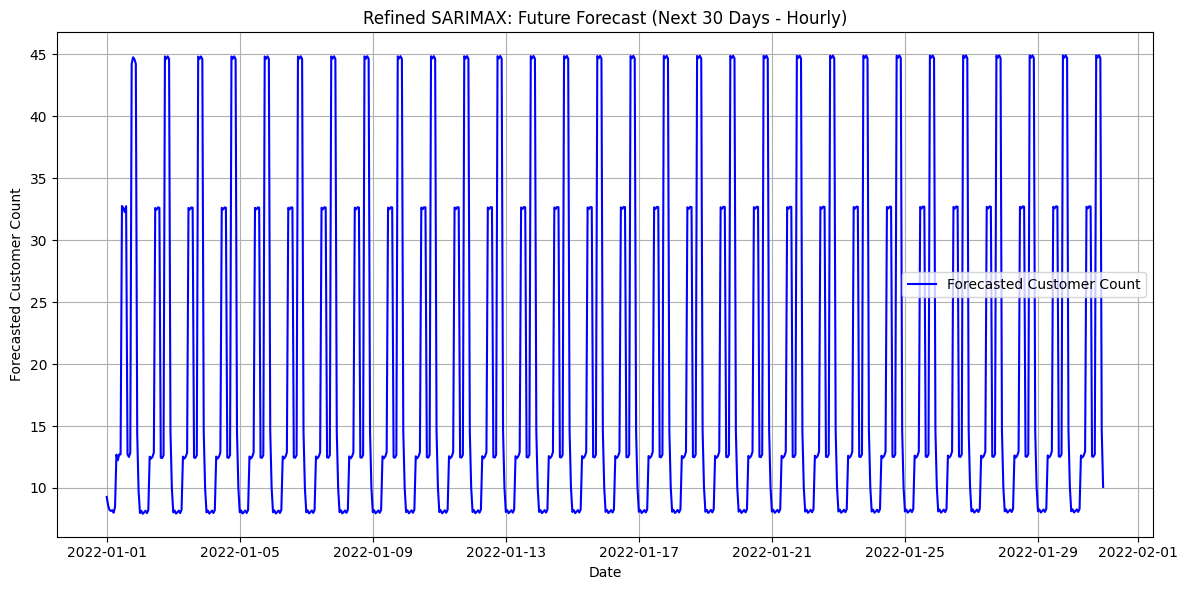

In [15]:
# --- Step 12: Plot Future Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_future_sarimax['ds'], forecast_future_sarimax['yhat'], color='blue', label='Forecasted Customer Count')
plt.title("Refined SARIMAX: Future Forecast (Next 30 Days - Hourly)")
plt.xlabel("Date")
plt.ylabel("Forecasted Customer Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()